<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=147106746" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [20]:
#!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  35.4857142857143

Range:  fear

Datetime:  2023-10-17 00:00:00+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [4]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2023-10-18.

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: SPR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 21.459999084472656

Ichimoku 9-Day Forecast: 18.56499981880188

Ichimoku 26-Day Forecast: 19.19499969482422

Choppiness (%): 35.84

RSI: 71.84160095410935

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

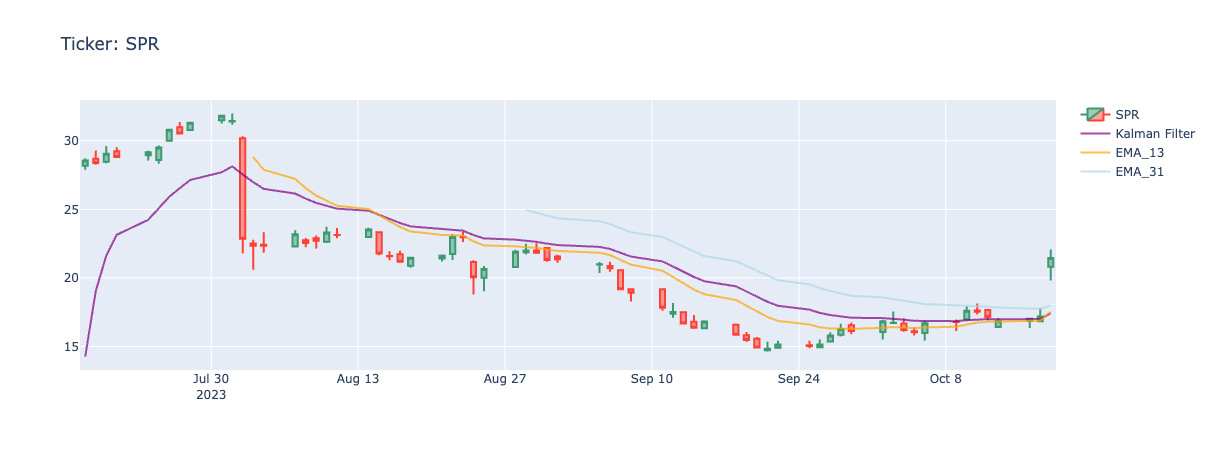

Ticker: GFIOF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 14.600000381469727

Ichimoku 9-Day Forecast: 12.485000133514404

Ichimoku 26-Day Forecast: 12.485000133514404

Choppiness (%): 15.15

RSI: 75.81687261259975

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

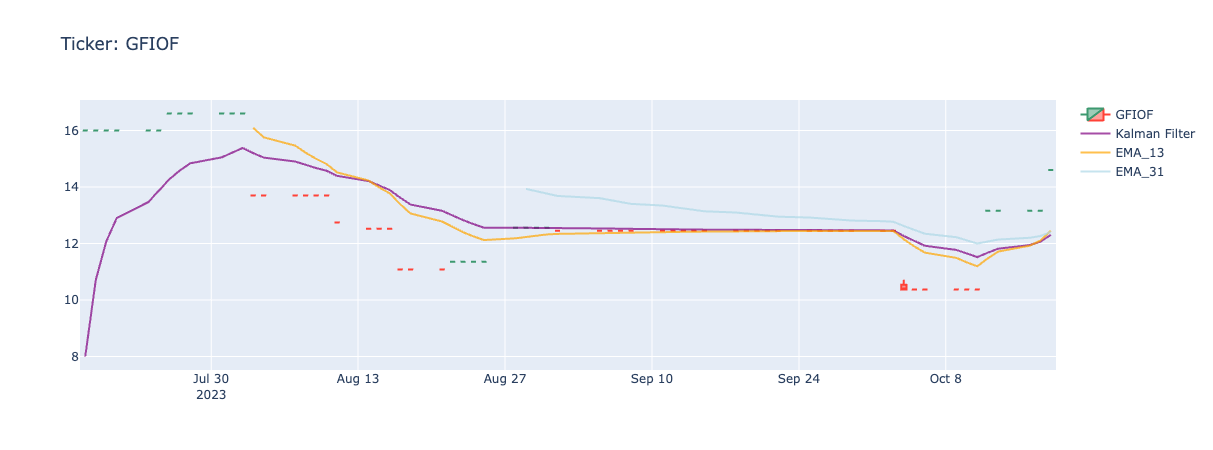

Ticker: NDAQ

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 52.380001068115234

Ichimoku 9-Day Forecast: 50.58695125579834

Ichimoku 26-Day Forecast: 50.51500129699707

Choppiness (%): 31.61

RSI: 65.960880593738

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

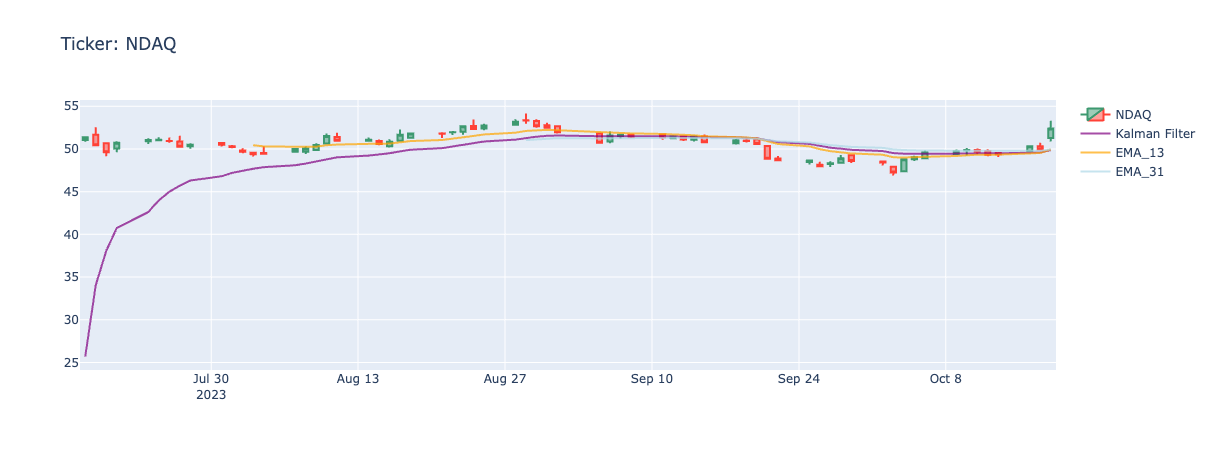

Ticker: TEO

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 5.880000114440918

Ichimoku 9-Day Forecast: 5.299000024795532

Ichimoku 26-Day Forecast: 5.335000038146973

Choppiness (%): 32.81

RSI: 71.96349516669662

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

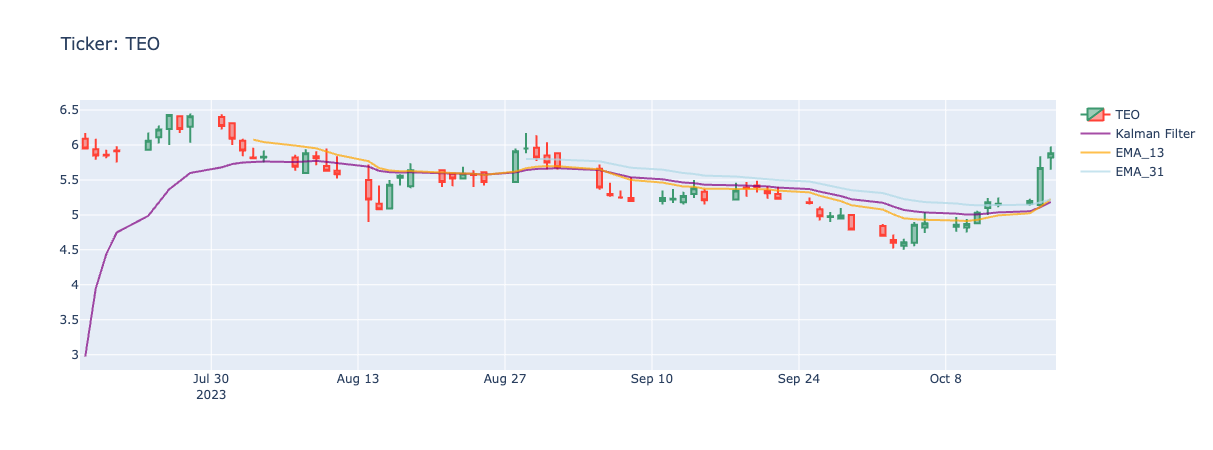

Ticker: FYBR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 18.594999313354492

Ichimoku 9-Day Forecast: 16.391249895095825

Ichimoku 26-Day Forecast: 16.25250005722046

Choppiness (%): 36.15

RSI: 71.70853987144893

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

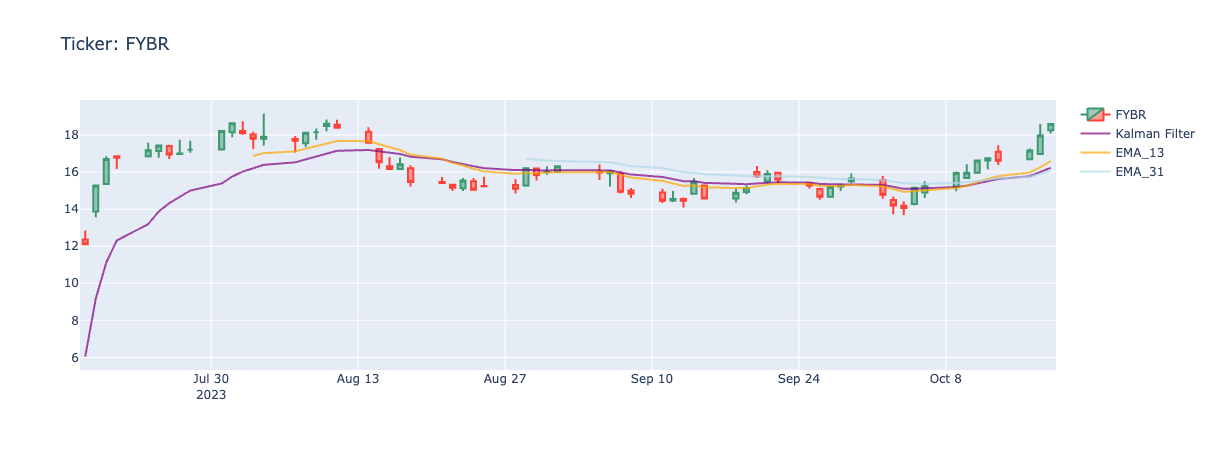

Ticker: SVNLY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 4.619999885559082

Ichimoku 9-Day Forecast: 4.442499995231628

Ichimoku 26-Day Forecast: 4.362499952316284

Choppiness (%): 32.21

RSI: 67.55631328663911

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

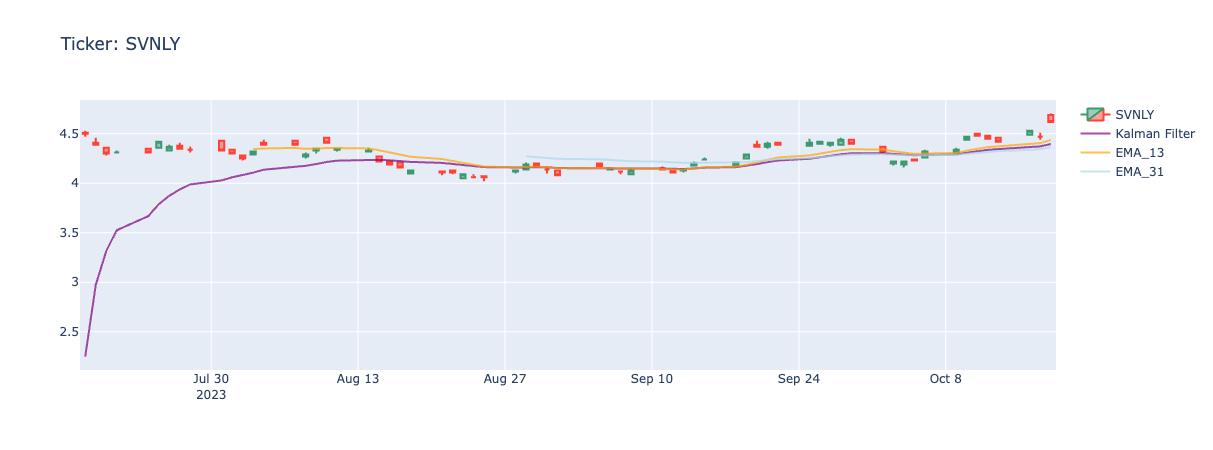

In [36]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[8] == True) & (calculate_symbol(v)[4]<="40"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: OPMXF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 60): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 0.7900000214576721

Ichimoku 9-Day Forecast: 0.8110000193119049

Ichimoku 26-Day Forecast: 0.8700000047683716

Choppiness (%): 52.12

RSI: 46.25159031316092

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

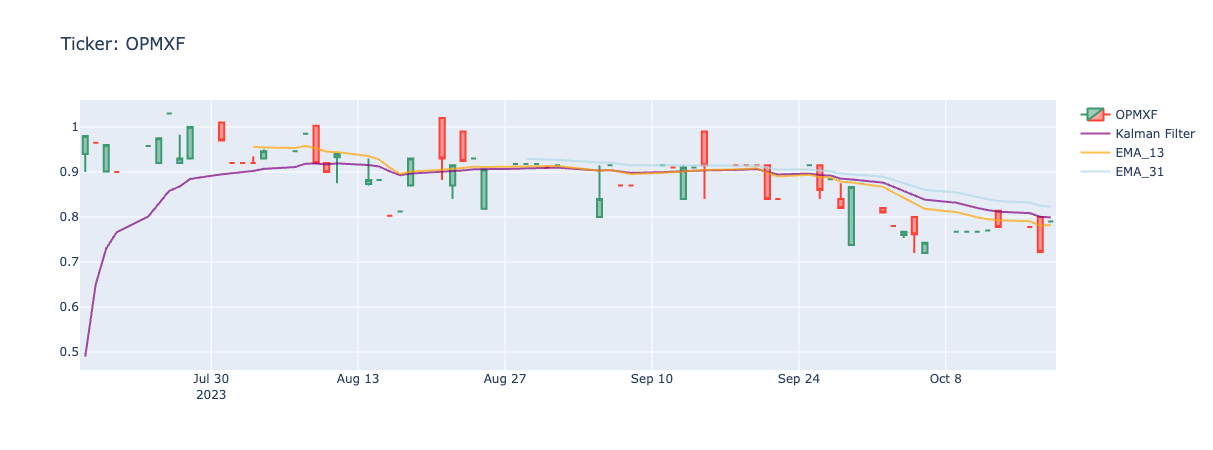

Ticker: DQJCY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 60): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 20.15999984741211

Ichimoku 9-Day Forecast: 20.257500171661377

Ichimoku 26-Day Forecast: 20.524999618530273

Choppiness (%): 57.75

RSI: 48.6207248332228

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

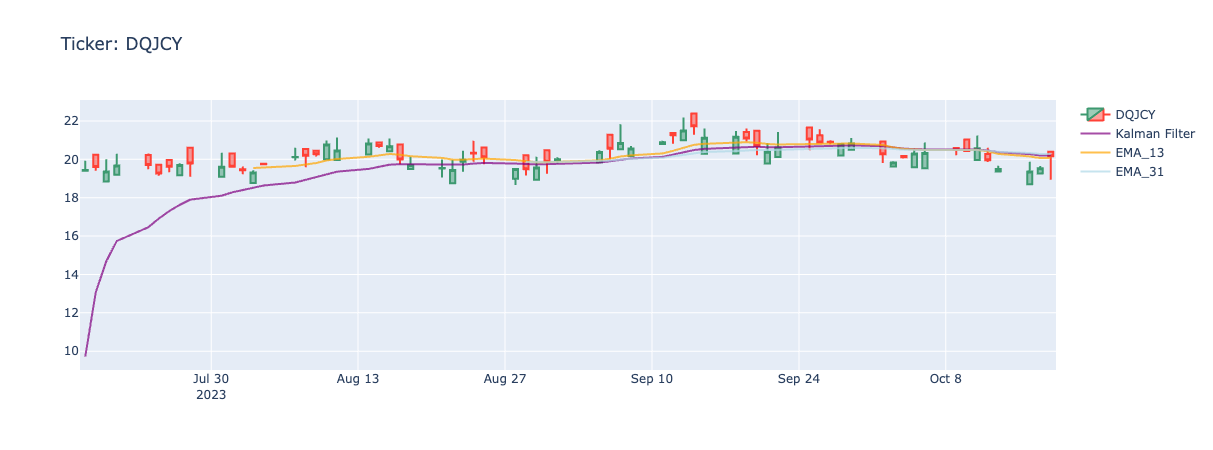

In [35]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[9] == True) & (calculate_symbol(v)[4] >= "50"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

In [40]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# Archer Moving Averages Trends (AMAT)
# https://tradingstrategy.ai/docs/_modules/pandas_ta/trend/amat.html#amat
# Source Code
# -*- coding: utf-8 -*-
from pandas import DataFrame
from .long_run import long_run
from .short_run import short_run
from pandas_ta.overlap import ma
from pandas_ta.utils import get_offset, verify_series


def amat(close=None, fast=None, slow=None, lookback=None, mamode=None, offset=None, **kwargs):
    """Indicator: Archer Moving Averages Trends (AMAT)"""
    # Validate Arguments
    fast = int(fast) if fast and fast > 0 else 8
    slow = int(slow) if slow and slow > 0 else 21
    lookback = int(lookback) if lookback and lookback > 0 else 2
    mamode = mamode.lower() if isinstance(mamode, str) else "ema"
    close = verify_series(close, max(fast, slow, lookback))
    offset = get_offset(offset)
    if "length" in kwargs: kwargs.pop("length")

    if close is None: return

    # # Calculate Result
    fast_ma = ma(mamode, close, length=fast, **kwargs)
    slow_ma = ma(mamode, close, length=slow, **kwargs)

    mas_long = long_run(fast_ma, slow_ma, length=lookback)
    mas_short = short_run(fast_ma, slow_ma, length=lookback)

    # Offset
    if offset != 0:
        mas_long = mas_long.shift(offset)
        mas_short = mas_short.shift(offset)

    # # Handle fills
    if "fillna" in kwargs:
        mas_long.fillna(kwargs["fillna"], inplace=True)
        mas_short.fillna(kwargs["fillna"], inplace=True)

    if "fill_method" in kwargs:
        mas_long.fillna(method=kwargs["fill_method"], inplace=True)
        mas_short.fillna(method=kwargs["fill_method"], inplace=True)

    # Prepare DataFrame to return
    amatdf = DataFrame({
        f"AMAT{mamode[0]}_LR_{fast}_{slow}_{lookback}": mas_long,
        f"AMAT{mamode[0]}_SR_{fast}_{slow}_{lookback}": mas_short
    })

    # Name and Categorize it
    amatdf.name = f"AMAT{mamode[0]}_{fast}_{slow}_{lookback}"
    amatdf.category = "trend"

    return amatdf

# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb
# https://www.tradingview.com/script/Z2mq63fE-Trade-Archer-Moving-Averages-v1-4F/

In [8]:
# soon to incorporate this charting method: https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

In [9]:
# en fin